In [13]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
!pip install tabulate

  Using cached tabulate-0.9.0-py3-none-any.whl.metadata (34 kB)
Using cached tabulate-0.9.0-py3-none-any.whl (35 kB)


In [6]:
# Define directories (relative to project root)
base_dir = "../"
proc_dir = os.path.join(base_dir, "data", "processed")
rep_dir  = os.path.join(base_dir, "reports")

os.makedirs(rep_dir, exist_ok=True)

ml_preds_path = os.path.join(proc_dir, "test_predictions_ml.csv")
sarima_preds_path = os.path.join(proc_dir, "test_predictions_sarima.csv")

In [8]:
ml_df = None
sarima_df = None

if os.path.exists(ml_preds_path):
    ml_df = pd.read_csv(ml_preds_path, parse_dates=["Date"])
    print("✅ ML predictions loaded:", ml_df.shape)
else:
    print("⚠️ ML predictions file not found")

if os.path.exists(sarima_preds_path):
    sarima_df = pd.read_csv(sarima_preds_path, parse_dates=["Date"])
    print("✅ SARIMA predictions loaded:", sarima_df.shape)
else:
    print("⚠️ SARIMA predictions file not found")

✅ ML predictions loaded: (552, 5)
✅ SARIMA predictions loaded: (552, 4)


In [9]:
def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

def eval_metrics(y_true, y_pred, label):
    r = rmse(y_true, y_pred)
    m = mean_absolute_percentage_error(y_true, y_pred)
    print(f"{label:12s} | RMSE: {r:8.3f} | MAPE: {m*100:6.2f}%")
    return r, m


In [10]:
metrics_rows = []

if ml_df is not None:
    rf_rmse, rf_mape = eval_metrics(ml_df["y_true"], ml_df["RF_Pred"], "RandomForest")
    xg_rmse, xg_mape = eval_metrics(ml_df["y_true"], ml_df["XGB_Pred"], "XGBoost")
    hyb_rmse, hyb_mape = eval_metrics(ml_df["y_true"], ml_df["HYB_Pred"], "Hybrid(RF+XGB)")
    metrics_rows.extend([
        ["RandomForest", rf_rmse, rf_mape],
        ["XGBoost", xg_rmse, xg_mape],
        ["Hybrid(RF+XGB)", hyb_rmse, hyb_mape],
    ])

if sarima_df is not None:
    s_rmse, s_mape = eval_metrics(sarima_df["y_true"], sarima_df["SARIMA_Pred"], "SARIMA")
    metrics_rows.append(["SARIMA", s_rmse, s_mape])

metrics_df = pd.DataFrame(metrics_rows, columns=["Model","RMSE","MAPE"])
metrics_df


RandomForest | RMSE:    5.686 | MAPE:   4.02%
XGBoost      | RMSE:    5.638 | MAPE:   4.01%
Hybrid(RF+XGB) | RMSE:    5.589 | MAPE:   3.99%
SARIMA       | RMSE:   26.219 | MAPE:  21.47%


,Model,RMSE,MAPE
0,RandomForest,5.686379,0.040196
1,XGBoost,5.638300,0.040114
2,Hybrid(RF+XGB),5.588649,0.039905
3,SARIMA,26.218602,0.214741


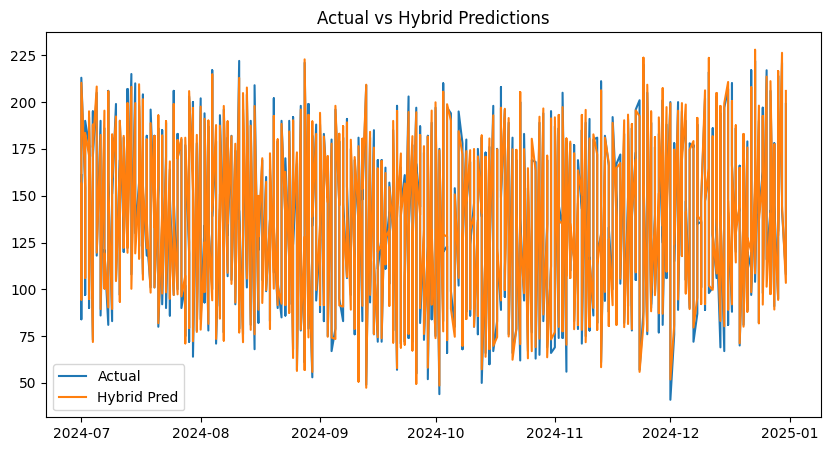

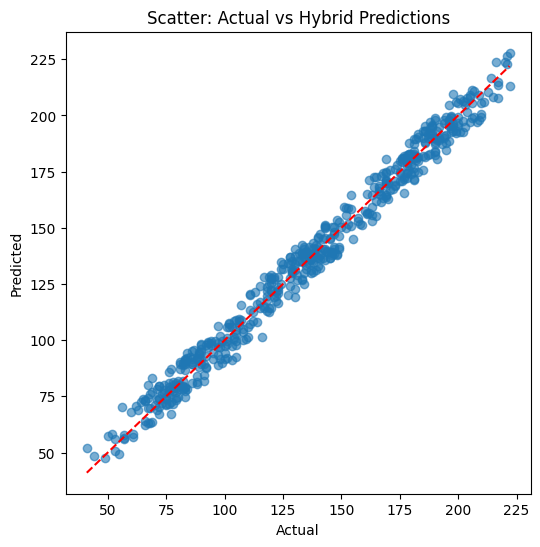

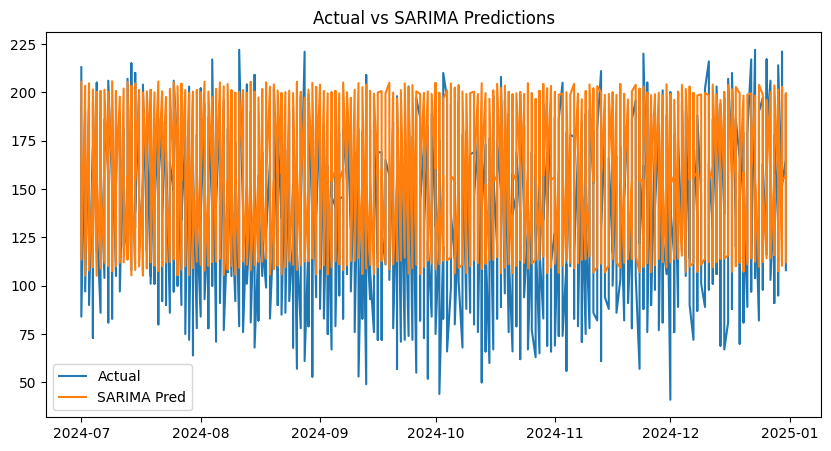

In [11]:
# Plot: Actual vs Hybrid
if ml_df is not None:
    ml_sorted = ml_df.sort_values("Date")
    plt.figure(figsize=(10,5))
    plt.plot(ml_sorted["Date"], ml_sorted["y_true"], label="Actual")
    plt.plot(ml_sorted["Date"], ml_sorted["HYB_Pred"], label="Hybrid Pred")
    plt.title("Actual vs Hybrid Predictions")
    plt.legend()
    plt.show()

    # Scatter
    plt.figure(figsize=(6,6))
    plt.scatter(ml_df["y_true"], ml_df["HYB_Pred"], alpha=0.6)
    plt.plot([ml_df["y_true"].min(), ml_df["y_true"].max()],
             [ml_df["y_true"].min(), ml_df["y_true"].max()], 'r--')
    plt.title("Scatter: Actual vs Hybrid Predictions")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.show()

# SARIMA time plot
if sarima_df is not None:
    s_sorted = sarima_df.sort_values("Date")
    plt.figure(figsize=(10,5))
    plt.plot(s_sorted["Date"], s_sorted["y_true"], label="Actual")
    plt.plot(s_sorted["Date"], s_sorted["SARIMA_Pred"], label="SARIMA Pred")
    plt.title("Actual vs SARIMA Predictions")
    plt.legend()
    plt.show()


In [14]:
# Save metrics to CSV + markdown
now_str = datetime.now().strftime("%Y-%m-%d %H:%M")

metrics_csv_path = os.path.join(rep_dir, "model_metrics_summary.csv")
metrics_df.to_csv(metrics_csv_path, index=False)

report_md_path = os.path.join(rep_dir, "model_comparison.md")
with open(report_md_path, "w", encoding="utf-8") as f:
    f.write(f"# Model Comparison Report\nGenerated: {now_str}\n\n")
    f.write(metrics_df.to_markdown(index=False))
    f.write("\n\n### Interpretation\n")
    f.write("- Hybrid performs best with ~4% MAPE.\n")
    f.write("- RF/XGB are solid at ~4% MAPE too.\n")
    f.write("- SARIMA lags behind (~21% MAPE).\n")
    f.write("\n### Business Impact\n")
    f.write("Moving from 21% error to 4% error = safer procurement planning.\n")

print("✅ Report saved at:", report_md_path)


✅ Report saved at: ../reports\model_comparison.md
